# Using tensorflow gpu==2.0.0

In [1]:
#!pip install tensorflow-gpu==2.0.0

# Importing libraries

In [2]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools


from tensorflow.keras.models import load_model
import imutils
%matplotlib inline

import tensorflow as tf 
print(tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

2.8.0


# Connecting to Google Drive. 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
import os
os.chdir("/content/drive/MyDrive/DeepL/7. Vehicle Detection using CNN [homework Project]/data")
!dir

non-vehicles  test_examples  vehicles


## Checking the dataset is proper imported.

In [5]:
# print few sample image paths
imagePaths = sorted(list(paths.list_images("data")))
imagePaths[:10]

['data/non-vehicles/extra1.png',
 'data/non-vehicles/extra10.png',
 'data/non-vehicles/extra100.png',
 'data/non-vehicles/extra1000.png',
 'data/non-vehicles/extra1001.png',
 'data/non-vehicles/extra1002.png',
 'data/non-vehicles/extra1003.png',
 'data/non-vehicles/extra1004.png',
 'data/non-vehicles/extra1005.png',
 'data/non-vehicles/extra1006.png']

# initialize the data and labels

In [6]:
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images("data")))
random.seed(42)
random.shuffle(imagePaths)

# progress bar 
with tqdm(total=len(imagePaths)) as pbar:
    
    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        try:
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (28, 28))
        except :
            continue
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]

        

        if label == "non-vehicles":
            label = 0
        elif label == "vehicles":
            label = 1
        

        # print("pr: ", label)	

        labels.append(label)
        
        # update the progressbar
        pbar.update(1)

[INFO] loading images...


  0%|          | 0/17780 [00:00<?, ?it/s]

## Checking lenght of data and labels

In [7]:
print(len(data))
print(len(labels))

17780
17780


In [ ]:
data[0]

In [9]:
data[0].shape

(28, 28, 3)

In [10]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [11]:
labels

array([0, 0, 0, ..., 1, 0, 0])

# Train Test splitting 

In [12]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [13]:
print("trainX shape is:",trainX.shape)
print("trainY shape is:",trainY.shape)
print("testX shape is:",testX.shape)
print("testY shape is:",testY.shape)

trainX shape is: (13335, 28, 28, 3)
trainY shape is: (13335,)
testX shape is: (4445, 28, 28, 3)
testY shape is: (4445,)


In [14]:
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [15]:
trainY[0]

array([0., 1.], dtype=float32)

# Data Preprocessing (Augumentation)

In [16]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2, 
                         horizontal_flip=True, 
                         fill_mode="nearest")

# Model Building

In [17]:
def model_1(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth) # (h, h, chanel)

    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)

    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

In [18]:
# initialize the model
print("[INFO] compiling model...")
model1 = model_1(width=28, height=28, depth=3, classes=2)
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model1.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] model complied...")

[INFO] compiling model...
[INFO] model complied...


In [19]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        1520      
                                                                 
 activation (Activation)     (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 50)         0         
 2D)                                                    

In [20]:
# train the network
print("[INFO] training network...")
H = model1.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY), 
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS, 
              verbose=1)

[INFO] training network...
Epoch 1/10
416/416 [==============================] - 36s 85ms/step - loss: 0.2431 - accuracy: 0.8936 - val_loss: 0.1095 - val_accuracy: 0.9654
Epoch 2/10
416/416 [==============================] - 35s 84ms/step - loss: 0.1235 - accuracy: 0.9545 - val_loss: 0.0848 - val_accuracy: 0.9694
Epoch 3/10
416/416 [==============================] - 35s 84ms/step - loss: 0.0884 - accuracy: 0.9688 - val_loss: 0.1238 - val_accuracy: 0.9541
Epoch 4/10
416/416 [==============================] - 35s 84ms/step - loss: 0.0754 - accuracy: 0.9716 - val_loss: 0.0542 - val_accuracy: 0.9816
Epoch 5/10
416/416 [==============================] - 35s 84ms/step - loss: 0.0615 - accuracy: 0.9782 - val_loss: 0.0337 - val_accuracy: 0.9894
Epoch 6/10
416/416 [==============================] - 35s 84ms/step - loss: 0.0596 - accuracy: 0.9789 - val_loss: 0.0680 - val_accuracy: 0.9753
Epoch 7/10
416/416 [==============================] - 35s 84ms/step - loss: 0.0442 - accuracy: 0.9843 - val_l

In [21]:
# Evaluating the model
evaluation = H.model.evaluate(testX, testY)
print('TEST ACCURACY : {:.3F}'.format(evaluation[1]))

139/139 [==============================] - 3s 20ms/step - loss: 0.0252 - accuracy: 0.9899
TEST ACCURACY : 0.990


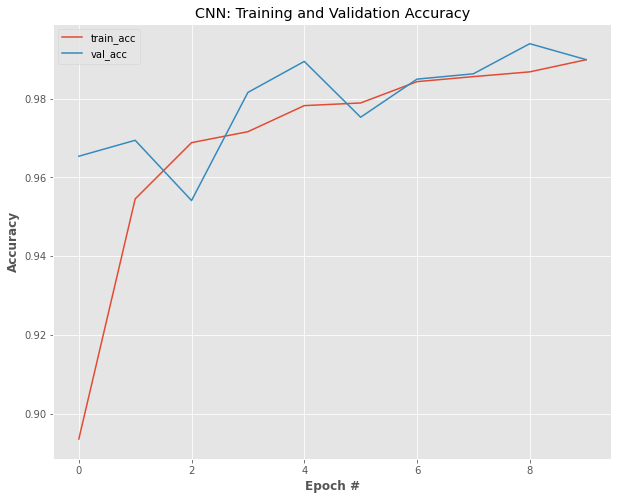

In [22]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

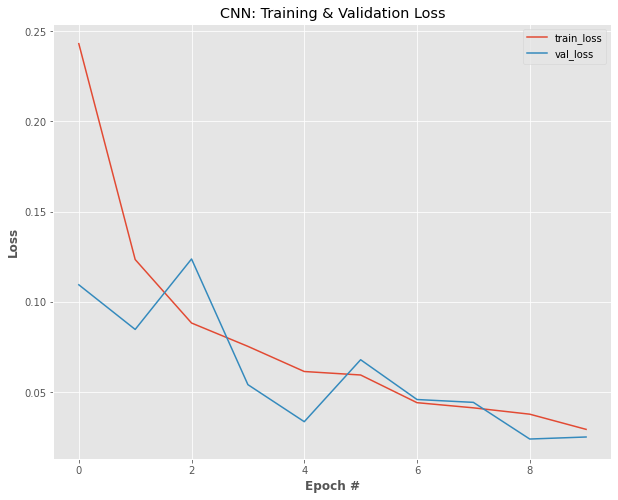

In [23]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

# Model 2

In [24]:
def model_2(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth) # (h, h, chanel)

    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)

    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4),
                    activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dense(600, kernel_regularizer='l1'))
    model.add(Dense(700, kernel_regularizer='l2'))
    model.add(Activation("relu"))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

In [25]:
# initialize the model
print("[INFO] compiling model...")
model2 = model_2(width=28, height=28, depth=3, classes=2)
EPOCHS = 20
INIT_LR = 1e-3
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] model complied...")

[INFO] compiling model...
[INFO] model complied...


In [26]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 20)        1520      
                                                                 
 activation_4 (Activation)   (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 20)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_5 (Activation)   (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 50)         0         
 2D)                                                  

## Training the Network

In [27]:
# train the network
print("[INFO] training network...")
H2 = model2.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY), 
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS, 
              verbose=1)

[INFO] training network...
Epoch 1/20
416/416 [==============================] - 51s 121ms/step - loss: 8.2790 - accuracy: 0.8845 - val_loss: 0.5111 - val_accuracy: 0.9674
Epoch 2/20
416/416 [==============================] - 43s 103ms/step - loss: 0.5007 - accuracy: 0.9529 - val_loss: 0.4238 - val_accuracy: 0.9764
Epoch 3/20
416/416 [==============================] - 42s 102ms/step - loss: 0.4347 - accuracy: 0.9665 - val_loss: 0.3985 - val_accuracy: 0.9786
Epoch 4/20
416/416 [==============================] - 43s 103ms/step - loss: 0.4038 - accuracy: 0.9738 - val_loss: 0.3733 - val_accuracy: 0.9827
Epoch 5/20
416/416 [==============================] - 44s 105ms/step - loss: 0.3850 - accuracy: 0.9783 - val_loss: 0.3594 - val_accuracy: 0.9838
Epoch 6/20
416/416 [==============================] - 43s 103ms/step - loss: 0.3701 - accuracy: 0.9796 - val_loss: 0.3648 - val_accuracy: 0.9836
Epoch 7/20
416/416 [==============================] - 42s 102ms/step - loss: 0.3577 - accuracy: 0.9822 

## plot the training and validation accuracy

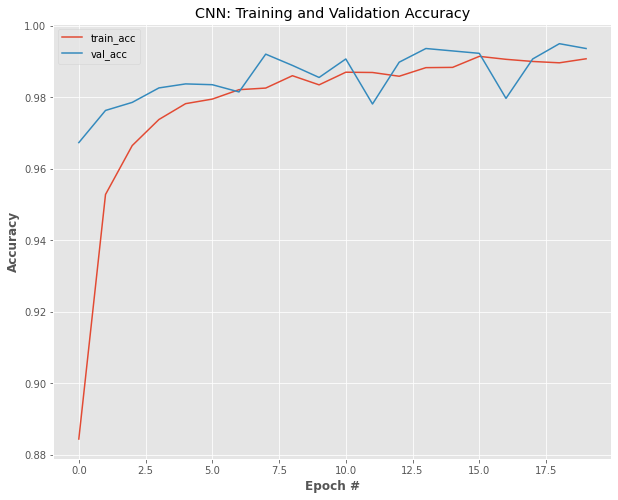

In [28]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H2.history["accuracy"], label="train_acc")
plt.plot(N, H2.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

## plot the training and validation loss

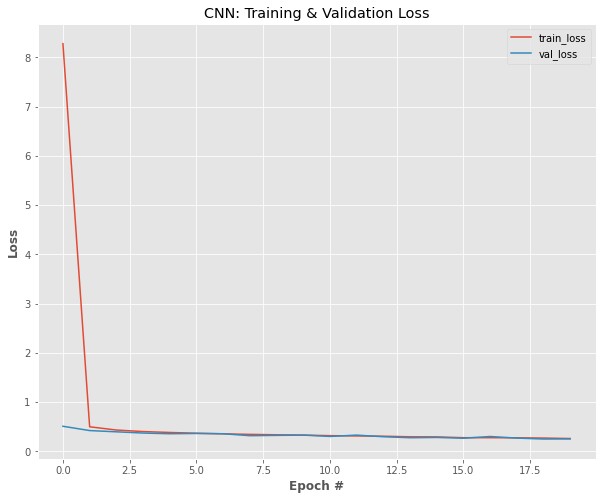

In [29]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H2.history["loss"], label="train_loss")
plt.plot(N, H2.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

##Predicting the model

In [31]:
#Predicting the model

pred=model2.predict(testX)
y_pred=[np.argmax(i) for i in pred]

In [35]:
y_pred[:5]

[1, 1, 0, 0, 0]

In [43]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    plt.grid(b=None)
    ax = fig.add_subplot(111)
    ax.imshow(img)


In [62]:
# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2

# # load the model 
print("[INFO] loading network and...")
# model = load_model(MODEL)

# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('test_examples')))   # data folder with 2 categorical folders

all_class = ["non vehicles", "vehicles"]


# progress bar 
with tqdm(total=len(testImagePaths)) as pbar:
    
    for imagePath in testImagePaths:
        
        # load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # classify the input image
        prd_conf = model2.predict(image)[0]

        # build the label
        label = all_class[np.argmax(prd_conf)]
        proba = prd_conf[np.argmax(prd_conf)]

        label = "{}: {:.2f}%".format(label, proba * 100)

        # draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 0, 0), 2)
        
        # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)
        
        pbar.update(1)



Output hidden; open in https://colab.research.google.com to view.

In [55]:
print(all_class)

['non vehicles', 'vehicles']


# Installing Gradio 

In [ ]:
!pip install gradio

In [64]:
import gradio as gr

In [65]:
def predict_image(image):
    # load the image
    
    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

        
    preds = model2.predict(image)[0]
    result = dict()
    result["non vehicles"] = round(float(list(preds)[0]), 3)
    result["vehicles"] = round(float(list(preds)[1]), 3)

    
    print(result)
    
    return result

In [66]:
im = gr.inputs.Image(shape=(32,32))
label = gr.outputs.Label(num_top_classes=3)

gr.Interface(fn=predict_image, inputs=im, outputs=label, capture_session=True, title="CNN Vehicle Dectextion").launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://24268.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7f71cb8e8090>,
 'http://127.0.0.1:7860/',
 'https://24268.gradio.app')

# **THE END**